In [111]:
# Fix imports when running from notebooks/ folder
import sys
from pathlib import Path

project_root = Path.cwd().parent 
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Added to path: {project_root}")

%load_ext autoreload
%autoreload 2

Added to path: /Users/elshaday/DEV/10Academy/intelligent-complaint-analysis-week7
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import src.data.loader as loader
import src.data.preprocessor as preprocessor
from scripts.constants import Columns, Processed_Columns, product_categories
from tabulate import tabulate
import matplotlib.pyplot as plt

In [3]:
data_loader = loader.DataLoader()
complaints_df = data_loader.load_from_csv()

Loaded ../data/raw/complaints.csv to Dataframe!


In [94]:
complaints_df_sample = complaints_df.sample(n=500000)

In [113]:
print("Data Description")
print(tabulate(complaints_df_sample.describe(include="all"), tablefmt="psql"))

Data Description
+--------+------------+-----------------------------------------------------+------------------+--------------------------------------+-------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+---------------+--------+--------+---------------+----------------------+--------+------------+-------------------------+--------+-------+------------------+
| count  | 500000     | 500000                                              | 487906           | 500000                

#### 1. Distribution of products

In [124]:
product_count = complaints_df_sample[Columns.PRODUCT.value].value_counts()
print(product_count)

Product
Credit reporting or other personal consumer reports                             251925
Credit reporting, credit repair services, or other personal consumer reports    112148
Debt collection                                                                  41524
Mortgage                                                                         22086
Checking or savings account                                                      15256
Credit card                                                                      11867
Credit card or prepaid card                                                      10752
Money transfer, virtual currency, or money service                                7532
Credit reporting                                                                  7127
Student loan                                                                      5761
Bank account or service                                                           4523
Vehicle loan or lease              

#### 2. Distribution of complaints across products

In [128]:
grouped_by_product = (
    complaints_df_sample.groupby(Columns.PRODUCT.value)[Columns.COMPLAINT.value]
    .count()
    .sort_values(ascending=False)
)
print(grouped_by_product)

Product
Credit reporting or other personal consumer reports                             56736
Credit reporting, credit repair services, or other personal consumer reports    41922
Debt collection                                                                 17491
Checking or savings account                                                      7308
Mortgage                                                                         6798
Credit card or prepaid card                                                      5600
Money transfer, virtual currency, or money service                               5087
Credit card                                                                      4255
Student loan                                                                     2751
Vehicle loan or lease                                                            2034
Credit reporting                                                                 1657
Payday loan, title loan, or personal loan     

#### 3. Number of complaints with and without narratives

In [129]:
number_of_complaints_with_narratives = complaints_df_sample[Columns.COMPLAINT.value].notna().sum()
number_of_complaints_without_narratives = (
    complaints_df_sample[Columns.COMPLAINT.value].isna().sum()
)

print(f"Number of complaints with narratives:", number_of_complaints_with_narratives)
print(f"Number of complaints without narratives:", number_of_complaints_without_narratives)

Number of complaints with narratives: 155029
Number of complaints without narratives: 344971


#### 4. Preprocess Data

In [145]:
# Preprocess Data
data_preprocessor = preprocessor.DataPreprocessor(complaints_df_sample)
working_df = data_preprocessor.get_processed_data()

Dropped 344971 rows containing null narratives.
New shape: (155029, 19)


#### 5. Customer narrative length analysis

In [146]:
working_df[Processed_Columns.WORD_COUNT.value] = (
    working_df[Columns.COMPLAINT.value].str.split().str.len()
)

print(tabulate(working_df[[Columns.COMPLAINT.value, Processed_Columns.WORD_COUNT.value]].head(), headers="keys", tablefmt="psql"))

+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|         | Consumer 

#### 6. Customer narrative visualization

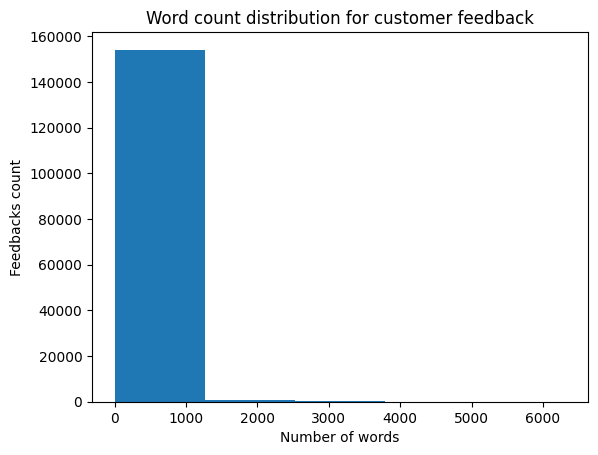

In [147]:
plt.hist(working_df[Processed_Columns.WORD_COUNT.value], bins=5)
plt.title("Word count distribution for customer feedback")
plt.xlabel("Number of words")
plt.ylabel("Feedbacks count")
plt.show()

#### 7. Include only records for the five specified products 

In [148]:
subset_df = data_preprocessor.subset_product_categories(working_df)
print(subset_df[Columns.PRODUCT.value].value_counts())


Product
Credit card                                  4255
Payday loan, title loan, or personal loan     875
Money transfers                                86
Name: count, dtype: int64


#### 8. Clean Customer Feedback column

In [151]:
clean_df = data_preprocessor.clean_and_normalize_customer_feedback(
    subset_df,
    Columns.COMPLAINT.value,
    Processed_Columns.CLEANED_COMPLAINT.value,
    Processed_Columns.NORMALIZED_COMPLAINT.value,
)
print(clean_df[Columns.COMPLAINT.value].head(10))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/elshaday/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elshaday/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


4607699    I want to start out this complaint by stating,...
539106     indigo credit card co of concord credit states...
6976194    i have received an offer for American express ...
7260504    See the attached documents. I want the bureau ...
1332416    I purchased an airline ticket back on XX/XX/XX...
9589204    Pay pal is issuing credit cards with a revolvi...
1917424    I attended a webinar where I was told I would ...
1001637    I called Capital One to see if they would be a...
7119499    I just realized that when I do n't pay the ful...
2169693    I reveived a CASHAP credit card in the mail I ...
Name: Consumer complaint narrative, dtype: object


/Users/elshaday/DEV/10Academy/intelligent-complaint-analysis-week7/src/data/preprocessor.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[normalized_col] = df[col].apply(tokenize_and_lemmatize)


#### 9. Save the cleaned data to a new CSV file

In [152]:
data_loader.save_to_csv(clean_df)

Saved dataframe to ../data/processed/complaints_clean.csv
